## Step-Well

In [1]:
import wandb
import tensorflow as tf
import numpy as np
from gpflow.config import default_float
from gpflow.likelihoods import Gaussian
import matplotlib.pyplot as plt

from docs.sde.sde_exp_utils import euler_maruyama
from markovflow.sde.sde import StepWellSDE
from markovflow.models.vi_sde import VariationalMarkovGP

from docs.sde.t_vgp_trainer import tVGPTrainer

2022-08-26 14:43:43.659444: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-26 14:43:43.659487: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-26 14:43:46.322252: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-26 14:43:46.323448: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-26 14:43:46.349047: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-08-26 14:43:46.349081: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: verma
2022-08-26 14:43:46.349091: I tensorflow/stream_execut

In [2]:
wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: prakharverma (vermaprakhar). Use `wandb login --relogin` to force relogin


In [3]:
DTYPE = default_float()

seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)

## Setup

In [4]:
t0 = 0
t1 = 10
dt = 0.1
noise_var = 0.001
n_observations = 10

# Define q
q = 2.5 * tf.ones((1, 1), dtype=DTYPE)

# Generate observations.
sde = StepWellSDE(q=q)

x0_shape = (1, 1)
x0 = -0.5 + tf.zeros(x0_shape, dtype=DTYPE)

time_grid = tf.cast(np.linspace(t0, t1, int((t1 - t0) // dt) + 2), dtype=DTYPE)

observation_idx = list(tf.cast(np.linspace(2, time_grid.shape[0] - 2, n_observations), dtype=tf.int32))
obs_t = tf.gather(time_grid, observation_idx)

latent_process = euler_maruyama(sde, x0, time_grid)
latent_states = tf.gather(latent_process, observation_idx, axis=1)
# Adding observation noise
obs_val = latent_states + tf.random.normal(latent_states.shape, stddev=np.sqrt(noise_var), dtype=DTYPE)

obs_val = tf.reshape(obs_val, (-1, 1))

observations = (obs_t, obs_val)
likelihood = Gaussian(variance=noise_var)

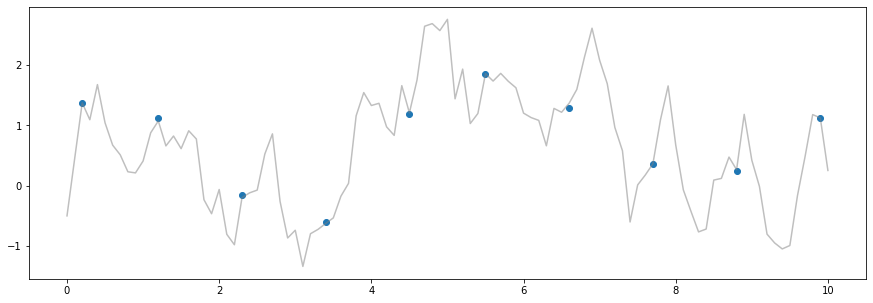

In [5]:
plt.subplots(1, 1, figsize=(15, 5))

plt.scatter(observations[0].numpy().reshape(-1), observations[1].numpy().reshape(-1))
plt.plot(time_grid.numpy().reshape(-1), latent_process.numpy().reshape(-1),color="gray", alpha=0.5)

plt.show()

## T-VGP Trainer

In [7]:
t_vgp_trainer_all_sites = tVGPTrainer(observations, likelihood, time_grid, sde, data_sites_lr=1.0, 
                                      update_all_sites=True)
t_vgp_trainer_all_sites.run()

t-VGP: Starting ELBO -7276.9689742283135;
t-VGP: Updating sites...
t-VGP: ELBO = -14.161040959857147
t-VGP: ELBO = -14.161040959857148
t-VGP: Sites converged! Linearizing...
t-VGP: ELBO before linearization -14.161040959857148!!!
t-VGP: ELBO after linearization -13.264082049047023!!!
ELBO diff : 0.8969588875770569 


t-VGP: ELBO before linearization -13.264082049047023!!!
t-VGP: ELBO after linearization -13.121542143253283!!!
ELBO diff : 0.14253990352153778 


t-VGP: ELBO before linearization -13.121542143253283!!!
t-VGP: ELBO after linearization -13.048931487685604!!!
ELBO diff : 0.07261065393686295 


t-VGP: ELBO before linearization -13.048931487685604!!!
t-VGP: ELBO after linearization -13.244674601501943!!!
ELBO decreasing!!!
ELBO diff : 0.1957431137561798 


t-VGP: ELBO before linearization -13.244674601501943!!!
t-VGP: ELBO after linearization -13.236441250606553!!!
ELBO diff : 0.008233350701630116 


t-VGP: ELBO before linearization -13.236441250606553!!!
t-VGP: ELBO after line

([-7276.9689742283135,
  -14.161040959857147,
  -14.161040959857148,
  -13.264082049047023,
  -13.121542143253283,
  -13.048931487685604,
  -13.244674601501943,
  -13.236441250606553,
  -13.236441250606553,
  -13.236441250606553,
  -13.236441250606553],
 {},
 {})

## Plot linearized Prior

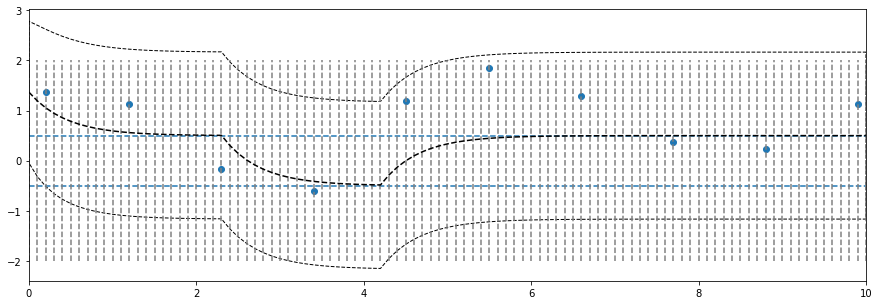

In [9]:
# Linearized prior
lin_m, lin_S = t_vgp_trainer_all_sites.tvgp_model.dist_p_ssm.marginals
lin_m = lin_m.numpy().reshape(-1)
lin_S_std = np.sqrt(lin_S.numpy()).reshape(-1)

# Plotting
plt.subplots(1, 1, figsize=(15, 5))
plt.scatter(observations[0].numpy().reshape(-1), observations[1].numpy().reshape(-1))
plt.fill_between(
    time_grid,
    y1=(lin_m.reshape(-1) - 2 * lin_S_std.reshape(-1)).reshape(-1, ),
    y2=(lin_m.reshape(-1) + 2 * lin_S_std.reshape(-1)).reshape(-1, ),
    edgecolor="black",
    facecolor=(0, 0, 0, 0.),
    linestyle='dashed'
)
plt.hlines(0.5, t0, t1, linestyles="dashed")
plt.hlines(-0.5, t0, t1, linestyles="dashed")

plt.vlines(time_grid.numpy().reshape(-1), -2, 2, linestyle="dashed", color="gray")

plt.plot(time_grid.numpy().reshape(-1), lin_m.reshape(-1), color="black", linestyle="dashed")

plt.xlim([t0, t1])
plt.show()

## c = -b/A

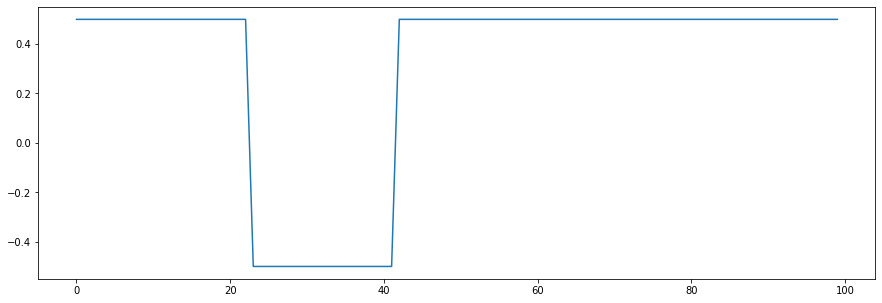

In [10]:
b = t_vgp_trainer_all_sites.tvgp_model.dist_p_ssm.state_offsets / dt
A = (t_vgp_trainer_all_sites.tvgp_model.dist_p_ssm.state_transitions - tf.eye(1, dtype=b.dtype)) / dt

A = A.numpy().reshape(-1)
b = b.numpy().reshape(-1)

plt.subplots(1, 1, figsize=(15, 5))
c = -b/A
plt.plot(c)
plt.show()

## Plot Posterior

In [11]:
m, S = t_vgp_trainer_all_sites.tvgp_model.dist_q.marginals
m = m.numpy().reshape(-1)
S_std = np.sqrt(S.numpy()).reshape(-1)

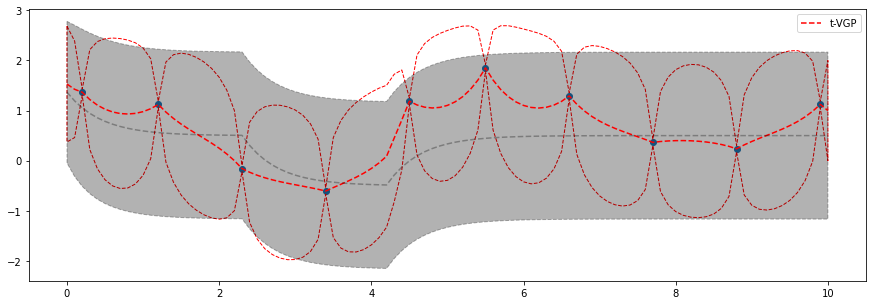

In [12]:
plt.subplots(1, 1, figsize=(15, 5))

plt.scatter(observations[0].numpy().reshape(-1), observations[1].numpy().reshape(-1))
plt.fill_between(
    time_grid,
    y1=(m.reshape(-1) - 2 * S_std.reshape(-1)).reshape(-1, ),
    y2=(m.reshape(-1) + 2 * S_std.reshape(-1)).reshape(-1, ),
    edgecolor="red",
    facecolor=(0, 0, 0, 0.),
    linestyle='dashed'
)

plt.plot(time_grid.numpy().reshape(-1), m.reshape(-1), color="red", linestyle="dashed", label="t-VGP")

plt.fill_between(
    time_grid,
    y1=(lin_m.reshape(-1) - 2 * lin_S_std.reshape(-1)).reshape(-1, ),
    y2=(lin_m.reshape(-1) + 2 * lin_S_std.reshape(-1)).reshape(-1, ),
    edgecolor="black",
    facecolor=(0, 0, 0, 0.),
    linestyle='dashed',
    alpha=0.3
)
plt.plot(time_grid.numpy().reshape(-1), lin_m.reshape(-1), color="black", linestyle="dashed", alpha=0.3)


plt.legend()
plt.show()


## VGP

In [13]:
vgp_model = VariationalMarkovGP(observations, sde, time_grid, likelihood, lr=0.0005, initial_state_lr=0.0001,
                                    convergence_tol=1e-4)

# Initialize VGP model
vgp_model.q_initial_cov = 0.5 + 0. * vgp_model.q_initial_cov
vgp_model.q_initial_mean = observations[1][0] + 0. * vgp_model.q_initial_mean
vgp_model.p_initial_mean = observations[1][0] + 0. * vgp_model.p_initial_mean
vgp_model.p_initial_cov = 0.5 + 0. * vgp_model.p_initial_cov

vgp_elbo_vals, _, _ = vgp_model.run(update_prior=False, update_initial_statistics=True)


VGP: Starting ELBO -10766.425438703003
VGP - q loop: ELBO -4335.557264894722
VGP - q loop: ELBO -2926.8555241007048
VGP - q loop: ELBO -2232.494135221605
VGP - q loop: ELBO -1817.8794869881638
VGP - q loop: ELBO -1550.1269157155964
VGP - q loop: ELBO -1378.9209206198116
VGP - q loop: ELBO -1297.3525034955305
VGP - q loop: ELBO -1363.5721070706247
VGP: q loop ELBO decreasing!!! Decaying LR!
VGP - q loop: ELBO -1535.9272833073946
VGP: q loop ELBO decreasing!!! Decaying LR!
VGP - q loop: ELBO -1702.9301973976203
VGP: q loop ELBO decreasing!!! Decaying LR!
VGP - q loop: ELBO -1818.1325941021285
VGP: q loop ELBO decreasing!!! Decaying LR!
VGP - q loop: ELBO -1888.5450301686988
VGP: q loop ELBO decreasing!!! Decaying LR!
VGP - q loop: ELBO -1932.1784386439435
VGP: q loop ELBO decreasing!!! Decaying LR!
VGP - q loop: ELBO -1959.0319782307906
VGP: q loop ELBO decreasing!!! Decaying LR!
VGP - q loop: ELBO -1974.6099365709063
VGP: q loop ELBO decreasing!!! Decaying LR!
VGP - q loop: ELBO -1983.1

VGP - x0 loop: ELBO -1991.8408947852868
VGP - x0 loop: ELBO -1991.8382999845169
VGP - x0 loop: ELBO -1991.835706486522
VGP - x0 loop: ELBO -1991.8331142909633
VGP - x0 loop: ELBO -1991.830523397502
VGP - x0 loop: ELBO -1991.8279338058035
VGP - x0 loop: ELBO -1991.8253455155318
VGP - x0 loop: ELBO -1991.8227585263428
VGP - x0 loop: ELBO -1991.8201728379022
VGP - x0 loop: ELBO -1991.8175884498721
VGP - q loop: ELBO -1991.8176597491674
VGP: Breaking q loop as ELBO converged!!!
VGP - x0 loop: ELBO -1991.8143350035903
VGP - x0 loop: ELBO -1991.8110128997212
VGP - x0 loop: ELBO -1991.807693436836
VGP - x0 loop: ELBO -1991.8043766142055
VGP - x0 loop: ELBO -1991.8010624311075
VGP - x0 loop: ELBO -1991.7977508868225
VGP - x0 loop: ELBO -1991.7944419806165
VGP - x0 loop: ELBO -1991.7911357117748
VGP - x0 loop: ELBO -1991.787832079565
VGP - x0 loop: ELBO -1991.7845310832697
VGP - x0 loop: ELBO -1991.7812327221607
VGP - x0 loop: ELBO -1991.777936995519
VGP - x0 loop: ELBO -1991.7746439026191
VGP 

VGP - x0 loop: ELBO -1990.9486434756022
VGP - x0 loop: ELBO -1990.9430022104832
VGP - x0 loop: ELBO -1990.937385889987
VGP - x0 loop: ELBO -1990.9317945067467
VGP - x0 loop: ELBO -1990.9262280533944
VGP - x0 loop: ELBO -1990.9206865225651
VGP - x0 loop: ELBO -1990.915169906896
VGP - x0 loop: ELBO -1990.909678199021
VGP - x0 loop: ELBO -1990.9042113915812
VGP - x0 loop: ELBO -1990.8987694772168
VGP - x0 loop: ELBO -1990.8933524485726
VGP - q loop: ELBO -1990.8934237787093
VGP: Breaking q loop as ELBO converged!!!
VGP - x0 loop: ELBO -1990.885908323764
VGP - x0 loop: ELBO -1990.8784477067354
VGP - x0 loop: ELBO -1990.8710419113227
VGP - x0 loop: ELBO -1990.863690921232
VGP - x0 loop: ELBO -1990.8563947201703
VGP - x0 loop: ELBO -1990.8491532918501
VGP - x0 loop: ELBO -1990.8419666199843
VGP - x0 loop: ELBO -1990.834834688295
VGP - x0 loop: ELBO -1990.8277574805074
VGP - x0 loop: ELBO -1990.8207349803433
VGP - x0 loop: ELBO -1990.8137671715358
VGP - x0 loop: ELBO -1990.80685403782
VGP - x

In [14]:
print(f"VGP model : {vgp_elbo_vals[-1]}")

VGP model : -1990.392322353581


In [15]:
m_vgp, S_vgp = vgp_model.forward_pass
m_vgp = m_vgp.numpy().reshape(-1)
S_std_vgp = np.sqrt(S_vgp.numpy()).reshape(-1)

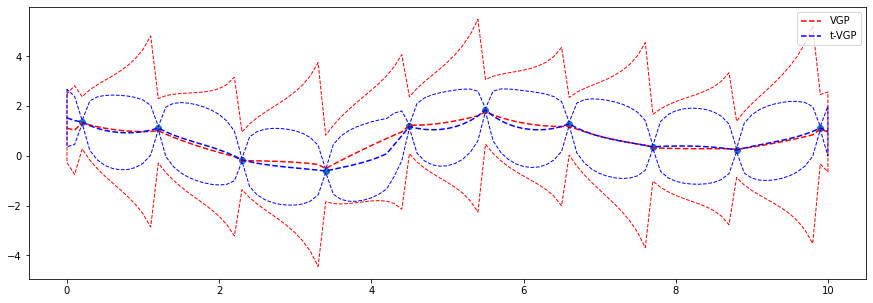

In [16]:
plt.subplots(1, 1, figsize=(15, 5))

plt.scatter(observations[0].numpy().reshape(-1), observations[1].numpy().reshape(-1))
plt.fill_between(
    time_grid,
    y1=(m_vgp.reshape(-1) - 2 * S_std_vgp.reshape(-1)).reshape(-1, ),
    y2=(m_vgp.reshape(-1) + 2 * S_std_vgp.reshape(-1)).reshape(-1, ),
    edgecolor="red",
    facecolor=(0, 0, 0, 0.),
    linestyle='dashed'
)

plt.plot(time_grid.numpy().reshape(-1), m_vgp.reshape(-1), color="red", linestyle="dashed", label="VGP")


plt.fill_between(
    time_grid,
    y1=(m.reshape(-1) - 2 * S_std.reshape(-1)).reshape(-1, ),
    y2=(m.reshape(-1) + 2 * S_std.reshape(-1)).reshape(-1, ),
    edgecolor="blue",
    facecolor=(0, 0, 0, 0.),
    linestyle='dashed'
)

plt.plot(time_grid.numpy().reshape(-1), m.reshape(-1), color="blue", linestyle="dashed", label="t-VGP")


plt.legend()
plt.show()
